In [10]:
import pandas as pd
import numpy as np

In [8]:
cleaned_file = "../../data/processed/2_cleaned_cgm.csv"  # Path to save the cleaned file
df = pd.read_csv(cleaned_file, nrows=100000)  # Load the cleaned data
df['time'] = pd.to_datetime(df['time'])

## CGM

In [7]:
def calc_bgi(glucose):
    """
    Calculate the Blood Glucose Index (BGI) based on glucose readings.

    Args:
        glucose (float): Glucose reading.
        units (str): Units of glucose measurement ('mmol/L' or 'mg/dL').

    Returns:
        float: Blood Glucose Index (BGI) value.

    Note:
        - The BGI calculation depends on the units of glucose.
        - The formula for BGI differs for 'mmol/L' and 'mg/dL'.
    """
    num1 = 1.794
    num2 = 1.026
    num3 = 1.861

    bgi = num1 * (np.log(glucose) ** num2 - num3)
    return bgi

def lbgi(glucose, units):
    """
    Calculate the Low Blood Glucose Index (LBGI) based on glucose readings.

    Args:
        glucose (float): Glucose reading.
        units (str): Units of glucose measurement ('mmol/L' or 'mg/dL').

    Returns:
        float: Low Blood Glucose Index (LBGI) value.

    Note:
        - The LBGI is calculated using the BGI value.
        - The LBGI is a measure of the risk associated with low blood glucose levels.
    """
    bgi = calc_bgi(glucose)
    lbgi = 10 * (min(bgi, 0) ** 2)
    return lbgi

def calculate_hbgi(glucose):
    """
    Calculate the High Blood Glucose Index (HBGI) based on glucose readings.

    Args:
        glucose (float): Glucose reading.
        units (str): Units of glucose measurement ('mmol/L' or 'mg/dL').

    Returns:
        float: High Blood Glucose Index (HBGI) value.

    Note:
        - The HBGI is calculated using the BGI value.
        - The HBGI is a measure of the risk associated with high blood glucose levels.
    """
    bgi = calc_bgi(glucose)
    hbgi = 10 * (max(bgi, 0) ** 2)
    return hbgi

In [8]:
import numpy as np

def calculate_hbgi(glucose):
    """
    Calculate the High Blood Glucose Index (HBGI) based on glucose readings.

    Args:
        glucose (float): Glucose reading.

    Returns:
        float: High Blood Glucose Index (HBGI) value.
    """
    # Apply the formula directly to calculate HBGI
    bgi_value = 1.794 * (np.log(glucose) ** 1.026 - 1.861)
    hbgi = 10 * max(bgi_value, 0) ** 2  # Only consider positive values for HBGI
    return hbgi

def calculate_lbgi(glucose):
    """
    Calculate the Low Blood Glucose Index (LBGI) based on glucose readings.

    Args:
        glucose (float): Glucose reading.

    Returns:
        float: Low Blood Glucose Index (LBGI) value.
    """
    # Apply the formula directly to calculate LBGI
    bgi_value = 1.794 * (np.log(glucose) ** 1.026 - 1.861)
    lbgi = 10 * min(bgi_value, 0) ** 2  # Only consider negative values for LBGI
    return lbgi


In [9]:
import pandas as pd
import numpy as np

# Convert 'time' columns to datetime if not done
cgms['time'] = pd.to_datetime(cgms['time'])
cgms.set_index('time', inplace=True)  # Set time as index for rolling operations

# Ensure data is sorted by ID and time for accurate rolling calculations
cgms.sort_values(['ID', 'time'], inplace=True)

In [28]:
# Define the rolling function for 1-hour metrics
def calculate_metrics(group):
    # Rolling 1-hour window
    rolled = group['glc'].rolling('1h')

    # Calculate metrics based on the rolling window
    group['avg_glucose'] = rolled.mean()
    group['sd_glucose'] = rolled.std()
    
    # Time in ranges
    group['time_below_3.9'] = rolled.apply(lambda x: (x < 3.9).mean(), raw=False)
    group['time_3.9_to_10'] = rolled.apply(lambda x: ((x >= 3.9) & (x <= 10)).mean(), raw=False)
    group['time_above_10'] = rolled.apply(lambda x: (x > 10).mean(), raw=False)

    # Calculate HBGI using a lambda function directly within apply for mg/dl
    group['hbgi'] = rolled.apply(
        lambda x: 10 * np.mean(np.square(np.maximum(1.794 * (np.log(x) ** 1.026 - 1.861), 0)))
        if len(x) >= 8 else np.nan,
        raw=False
    )

    # Calculate LBGI using a lambda function directly within apply
    group['lbgi'] = rolled.apply(
        lambda x: 10 * np.mean(np.square(np.minimum(1.794 * (np.log(x) ** 1.026 - 1.861), 0)))
        if len(x) >= 8 else np.nan,
        raw=False
    )

    # 

    return group


In [29]:
# Apply the rolling function to each ID group
cgms = cgms.groupby('ID', group_keys=False).apply(calculate_metrics)

# Reset index if you want 'time' as a regular column again
cgms.reset_index(inplace=True)

/tmp/ipykernel_1182018/651175261.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  rolled = group['glc'].rolling('1H', min_periods=8)
/tmp/ipykernel_1182018/651175261.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  rolled = group['glc'].rolling('1H', min_periods=8)
/tmp/ipykernel_1182018/651175261.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  rolled = group['glc'].rolling('1H', min_periods=8)
/tmp/ipykernel_1182018/651175261.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  rolled = group['glc'].rolling('1H', min_periods=8)
/tmp/ipykernel_1182018/651175261.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  rolled = group['glc'].rolling('1H', min_periods=8)
/tmp/ipykernel_1182018/651175261.py:4: FutureWarni

<Axes: >

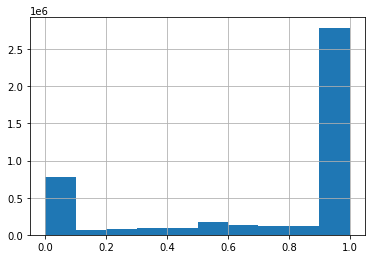

In [33]:
cgms['time_3.9_to_10'].hist()

In [38]:
# Use shift to get the reading 20 minutes ago directly using the calculated steps
cgms['glc_20_min_ago'] = cgms.groupby('ID')['glc'].shift(4)

# Calculate ROC
cgms['start_roc'] = (cgms['glc'] - cgms['glc_20_min_ago']) / 20

In [40]:
cgms.to_csv('../../data/tidy/paired_data/paired_cgms.csv', index=False)

## IOB

In [6]:
ins_cut = ins[ins['ID'] == 'dexip_100']

In [5]:
import pandas as pd
from datetime import timedelta

def calculate_iob(dose, time_diff, dia=4):
    """
    Calculate Insulin on Board (IOB) for a given dose and time difference,
    with linear degradation over the duration of insulin action (DIA).
    """
    if time_diff > timedelta(hours=dia):
        return 0  # No insulin effect beyond DIA
    remaining_fraction = (dia - time_diff.total_seconds() / 3600) / dia
    return dose * remaining_fraction

def generate_iob_timeseries(insulin_data, dia=4):
    """
    Generate a minute-by-minute IOB time series based on insulin doses and times,
    only filling in values within the duration of insulin action (DIA), and sum overlapping doses.

    Args:
        insulin_data (pd.DataFrame): DataFrame with columns 'ID', 'time', 'dose'.
        dia (int): Duration of insulin action in hours.

    Returns:
        pd.DataFrame: Minute-by-minute DataFrame with columns 'ID', 'time', 'IOB'.
    """
    # Create a list to store the raw IOB values
    iob_series = []

    # Loop through each participant
    for participant_id, group in insulin_data.groupby('ID'):
        # Ensure insulin doses are sorted by time
        group = group.sort_values('time').reset_index(drop=True)
        
        # Loop over each dose event
        for _, row in group.iterrows():
            dose_time = row['time']
            dose = row['dose']
            
            # Generate a time range for the duration of insulin action (DIA)
            end_time = dose_time + timedelta(hours=dia)
            timeline = pd.date_range(start=dose_time, end=end_time, freq='min')
            
            # Calculate IOB for each minute in this 4-hour window
            for current_time in timeline:
                time_diff = current_time - dose_time
                iob = calculate_iob(dose, time_diff, dia)
                
                # Append the IOB at the current time to the series
                iob_series.append({'ID': participant_id, 'time': current_time, 'IOB': iob})

    # Convert the list to a DataFrame
    iob_df = pd.DataFrame(iob_series)
    
    # Sum IOB for overlapping times by grouping on 'ID' and 'time'
    iob_df = iob_df.groupby(['ID', 'time'], as_index=False).agg({'IOB': 'sum'})

    return iob_df

# Example usage:
# insulin_data['time'] = pd.to_datetime(insulin_data['time'])  # Ensure 'time' is in datetime format
# iob_df = generate_iob_timeseries(insulin_data)
# print(iob_df.head())


In [17]:
import pandas as pd
from datetime import timedelta

def calculate_iob(dose, time_diff, dia=4):
    if time_diff > timedelta(hours=dia):
        return 0
    remaining_fraction = (dia - time_diff.total_seconds() / 3600) / dia
    return dose * remaining_fraction

def generate_iob_timeseries(insulin_data, dia=4):
    iob_series = []

    for participant_id, group in insulin_data.groupby('ID'):
        group = group.sort_values('time').reset_index(drop=True)
        
        for _, row in group.iterrows():
            dose_time = row['time']
            dose = row['dose']
            
            end_time = dose_time + timedelta(hours=dia)
            timeline = pd.date_range(start=dose_time, end=end_time, freq='min')
            
            for current_time in timeline:
                time_diff = current_time - dose_time
                iob = calculate_iob(dose, time_diff, dia)
                iob_series.append({'ID': participant_id, 'time': current_time, 'IOB': iob})

        # Convert to DataFrame and save each participant's data separately to save memory
        iob_df = pd.DataFrame(iob_series)
        
        # Sum overlapping doses by grouping on ID and time
        iob_df = iob_df.groupby(['ID', 'time'], as_index=False).agg({'IOB': 'sum'})
        
        # Append to a CSV or parquet file, then clear memory for the next batch
        iob_df.to_csv(f'../../data/tidy/paired_data/iob_per_min/{participant_id}.csv', index=False)
        iob_series.clear()  # Clear list to free up memory

# Load your insulin data and process it
# insulin_data['time'] = pd.to_datetime(insulin_data['time'])
generate_iob_timeseries(ins)


## Combining

In [11]:
cgms = pd.read_csv('../../data/tidy/paired_data/paired_cgms.csv')
cgms['time'] = pd.to_datetime(cgms['time']).dt.round('1min')  # Ensure 'time' is in datetime format

In [20]:
import pandas as pd
import os

# Initialize a list to hold merged DataFrames
merged_data = []

# Define the directory containing IOB files
iob_directory = '../../data/tidy/paired_data/iob_per_min/'

# Loop over each CSV file in the directory
for iob_file in os.listdir(iob_directory):
    if iob_file.endswith('.csv'):  # Ensure only CSV files are processed
        # Load the IOB data
        iob_data = pd.read_csv(os.path.join(iob_directory, iob_file))
        iob_data['time'] = pd.to_datetime(iob_data['time']).dt.round('1min')  # Ensure 'time' is datetime format
        # Sum IOB from all overlapping doses at each minute
        iob_data = iob_data.groupby(['ID', 'time'], as_index=False).agg({'IOB': 'sum'})
        print(iob_data.head())
        # Get the participant ID from the IOB data
        participant_id = iob_data['ID'].iloc[0]  # Assuming ID is the same for all rows in the file

        # Filter CGM data for the current participant
        cgm_participant_data = cgms[cgms['ID'] == participant_id]

        # Merge on 'ID' and 'time' using a left join to keep only 5-minute CGM intervals
        merged = pd.merge(cgm_participant_data, iob_data, on=['ID', 'time'], how='left')

        # Append the merged DataFrame to the list
        merged_data.append(merged)


          ID                time       IOB
0  helm_1719 2020-09-29 07:33:00  3.860000
1  helm_1719 2020-09-29 07:34:00  3.843917
2  helm_1719 2020-09-29 07:35:00  3.827833
3  helm_1719 2020-09-29 07:36:00  3.811750
4  helm_1719 2020-09-29 07:37:00  3.795667
         ID                time       IOB
0  helm_235 2020-01-15 00:56:00  0.116000
1  helm_235 2020-01-15 00:57:00  0.115517
2  helm_235 2020-01-15 00:58:00  0.115033
3  helm_235 2020-01-15 00:59:00  0.114550
4  helm_235 2020-01-15 01:00:00  0.114067
         ID                time     IOB
0  helm_137 2020-05-21 07:44:00  3.0000
1  helm_137 2020-05-21 07:45:00  2.9875
2  helm_137 2020-05-21 07:46:00  2.9750
3  helm_137 2020-05-21 07:47:00  2.9625
4  helm_137 2020-05-21 07:48:00  2.9500
          ID                time     IOB
0  dexip_125 2022-06-15 11:15:00  3.0000
1  dexip_125 2022-06-15 11:16:00  2.9875
2  dexip_125 2022-06-15 11:17:00  2.9750
3  dexip_125 2022-06-15 11:18:00  2.9625
4  dexip_125 2022-06-15 11:19:00  2.9500
    

In [21]:
# Concatenate all merged DataFrames into a single DataFrame
final_merged_data = pd.concat(merged_data, ignore_index=True)

In [38]:
final_merged_data['glc_post_10'] = final_merged_data.groupby('ID')['glc'].shift(-2)
final_merged_data['glc_post_20'] = final_merged_data.groupby('ID')['glc'].shift(-4)
final_merged_data['glc_post_40'] = final_merged_data.groupby('ID')['glc'].shift(-8)
final_merged_data['glc_post_60'] = final_merged_data.groupby('ID')['glc'].shift(-12)

In [39]:
# Save or further analyze the final merged dataset
final_merged_data.to_csv('../../data/tidy/paired_data/merged_cgm_iob_data.csv', index=False)  # Save if needed

In [24]:
final_merged_data.tail(20)

,time,ID,glc,avg_glucose,sd_glucose,time_below_3.9,time_3.9_to_10,time_above_10,hbgi,glc_20_min_ago,start_roc,IOB,glc_post_40
4436059,2020-06-07 22:21:00,helm_498,11.44,10.516154,0.988859,0.0,0.307692,0.692308,9.706783,11.17,0.0135,1.346200,9.56
4436060,2020-06-07 22:26:00,helm_498,10.39,10.776667,0.714949,0.0,0.166667,0.833333,10.545188,11.44,-0.0525,2.152329,9.50
4436061,2020-06-07 22:31:00,helm_498,9.89,10.818333,0.637122,0.0,0.166667,0.833333,10.677388,11.50,-0.0805,2.088267,9.39
4436062,2020-06-07 22:36:00,helm_498,9.83,10.809167,0.651536,0.0,0.166667,0.833333,10.647356,11.72,-0.0945,2.024204,9.22
4436063,2020-06-07 22:41:00,helm_498,10.17,10.760000,0.648498,0.0,0.153846,0.846154,10.471601,11.44,-0.0635,1.960142,9.22
4436064,2020-06-07 22:46:00,helm_498,10.28,10.764615,0.644536,0.0,0.153846,0.846154,10.487346,10.39,-0.0055,1.896079,9.28
4436065,2020-06-07 22:51:00,helm_498,10.00,10.726667,0.705850,0.0,0.250000,0.750000,10.363075,9.89,0.0055,1.832017,9.33
4436066,2020-06-07 22:56:00,helm_498,9.78,10.653846,0.725012,0.0,0.307692,0.692308,10.109874,9.83,-0.0025,1.767954,9.22
4436067,2020-06-07 23:01:00,helm_498,9.56,10.500000,0.791891,0.0,0.416667,0.583333,9.584396,10.17,-0.0305,1.703892,8.67
4436068,2020-06-07 23:06:00,helm_498,9.50,10.338333,0.780487,0.0,0.500000,0.500000,9.024213,10.28,-0.0390,1.639829,7.94


Next steps:
1. Build propensity model
2. Run the iteration the same as before, but this time search for the closest propensity score
3. As long as it's 0.01 "caliper", all good in the hood

## Diaries

In [25]:
final_merged_data = pd.read_csv('../../data/tidy/paired_data/merged_cgm_iob_data.csv')  # Save if needed

In [26]:
final_merged_data['time'] = pd.to_datetime(final_merged_data['time'])

In [27]:
directory_helm = '../../../hypo-predict/data/tidy_data/helmsley/'
directory_dexip = '../../../hypo-predict/data/tidy_data/dexip/'

In [28]:
# Preprocesed T1-DEXI dataset
helmsley_diaries = pd.read_csv(directory_helm + 'exercise.csv')
helmsley_diaries['start_datetime'] = pd.to_datetime(helmsley_diaries['start_datetime'])
helmsley_diaries['finish_datetime'] = pd.to_datetime(helmsley_diaries['finish_datetime'])
helmsley_diaries['study'] = 'helm'

# Preprocesed T1-DEXIP dataset
dexip_diaries = pd.read_csv(directory_dexip + 'exercise.csv')
dexip_diaries['start_datetime'] = pd.to_datetime(dexip_diaries['start_datetime'])
dexip_diaries['finish_datetime'] = pd.to_datetime(dexip_diaries['finish_datetime'])

dexip_diaries['study'] = 'dexip'

# Combine diaries
diaries = pd.concat([helmsley_diaries, dexip_diaries])import statsmodels.api as sm
import statsmodels.formula.api as smf

# Assuming 'glc_change' is your dependent variable and 'flag' is your main fixed effect
model = smf.mixedlm(
    "glc_change ~  exercise *(glc +  start_roc) ", #  +C(insulin_modality)+ age + bmi  time_3_9_to_10 +hour_of_day+ time_above_10 + hbgi + avg_glucose + + exercise:age + exercise:bmi
    data=df_cut_final_demo,
    groups="ID",  # Indidf_cut_final_demovidual-level random effect
    re_formula="~1+exercise",  # Allows random intercepts by ID
    vc_formula={"bout_id": "0 + C(bout_id)"},  # Nested pair-level random effect
)
result = model.fit(reml=True)


In [42]:
merged_df[merged_df['ID']=='helm_1719']

,ID,start_datetime,duration,intensity,type_of_exercise,finish_datetime,month,day,day_of_week,time_of_day,...,time_below_3.9,time_3.9_to_10,time_above_10,hbgi,glc_20_min_ago,start_roc,IOB,glc_post_40,time_post_20,glc_post_20
14917,helm_1719,2020-09-29 10:25:23,25.0,2.0,Study Video,2020-09-29 10:50:23,9,29,1,morning,...,0.000000,0.333333,0.666667,8.727431,10.17,-0.0835,1.668771,5.06,2020-09-29 11:12:00,4.44
14918,helm_1719,2020-09-29 10:57:16,6.0,0.0,Cleaning/Housework,2020-09-29 11:03:16,9,29,1,morning,...,0.000000,0.916667,0.083333,2.924246,7.17,-0.0835,1.013979,5.78,2020-09-29 11:27:00,4.78
14919,helm_1719,2020-09-29 13:36:42,15.0,1.0,Outdoor Chores,2020-09-29 13:51:42,9,29,1,afternoon,...,0.000000,0.750000,0.250000,6.312206,9.44,-0.0415,2.796804,3.78,2020-09-29 14:12:00,3.78
14920,helm_1719,2020-10-01 08:20:12,12.0,0.0,Cleaning/Housework,2020-10-01 08:32:12,10,1,3,morning,...,0.000000,0.666667,0.333333,4.979709,9.89,0.0415,4.006042,10.33,2020-10-01 08:57:00,10.33
14921,helm_1719,2020-10-01 08:32:54,20.0,0.0,gardening,2020-10-01 08:52:54,10,1,3,morning,...,0.000000,0.416667,0.583333,7.817967,10.39,0.0390,3.712917,10.06,2020-10-01 09:17:00,10.06
14922,helm_1719,2020-10-01 16:00:38,20.0,1.0,Outdoor Chores,2020-10-01 16:20:38,10,1,3,afternoon,...,0.000000,1.000000,0.000000,0.069240,5.50,-0.0055,1.298792,4.22,2020-10-01 16:42:00,4.00
14923,helm_1719,2020-10-01 16:25:02,20.0,1.0,Outdoor Chores,2020-10-01 16:45:02,10,1,3,afternoon,...,0.000000,1.000000,0.000000,0.000000,5.22,-0.0275,0.854000,3.56,2020-10-01 17:07:00,3.61
14924,helm_1719,2020-10-02 11:14:12,40.0,0.0,Outdoor Chores,2020-10-02 11:54:12,10,2,4,morning,...,0.000000,0.916667,0.083333,4.816031,8.67,-0.0085,0.638867,7.83,2020-10-02 12:17:00,7.33
14925,helm_1719,2020-10-03 10:18:07,24.0,2.0,Study Video,2020-10-03 10:42:07,10,3,5,morning,...,0.000000,0.083333,0.916667,10.144654,11.06,-0.0560,1.739421,6.72,2020-10-03 11:07:00,6.22
14926,helm_1719,2020-10-04 07:46:39,10.0,0.0,Cleaning/Housework,2020-10-04 07:56:39,10,4,6,morning,...,0.000000,1.000000,0.000000,0.002728,4.89,0.0775,4.312000,11.11,2020-10-04 08:17:00,10.44


In [29]:
final_merged_data.dropna(subset=['avg_glucose', 'glc_post_40'], inplace=True)

In [31]:
final_merged_data.reset_index(drop=True, inplace=True)

In [32]:
diaries.reset_index(drop=True, inplace=True)

In [33]:
diaries['finish_time_post_20'] = diaries['finish_datetime'] + pd.Timedelta('20min')

In [34]:
# Initialize an empty list to collect results for each group
merged_results = []

# Iterate over each ID in `final_merged_data` and `diaries`
for participant_id in diaries['ID'].unique():
    # Filter data for the current participant
    final_merged_subset = final_merged_data[final_merged_data['ID'] == participant_id].sort_values('time')
    diaries_subset = diaries[diaries['ID'] == participant_id].sort_values('start_datetime')
    
    # Perform the merge_asof for this participant's data
    merged_subset = pd.merge_asof(
        diaries_subset,
        final_merged_subset,
        by='ID',
        left_on='start_datetime',
        right_on='time',
        direction='backward',
        tolerance=pd.Timedelta('20min')  # Only merge if within 20 minutes
    )

    merged_subset_finish_time_post_20 = pd.merge_asof(
        merged_subset,
        final_merged_subset[['ID', 'time', 'glc']],
        suffixes=('', '_post_20'),
        by='ID',
        left_on='finish_time_post_20',
        right_on='time',
        direction='forward',
        tolerance=pd.Timedelta('20min')  # Only merge if within 20 minutes
    )

    # Append the merged subset to the results list
    merged_results.append(merged_subset_finish_time_post_20)

# Concatenate all merged results into a single DataFrame
merged_df = pd.concat(merged_results, ignore_index=True)

In [56]:
merged_df = pd.concat(merged_results, ignore_index=True)

In [57]:
merged_df.to_csv('../../data/tidy/paired_data/merged_cgm_iob_exercise_data.csv', index=False)